# 0. Environment Setup & Reproducibility

In [1]:
# Environment Setup
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from collections import Counter
from PIL import Image
import hashlib
import imagehash
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

# GPU Info
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Seed fixed: 42
Torch version: 2.9.0+cpu
CUDA available: False


# 1. Dataset Overview

**1.1 Load Dataset Paths**

In [2]:
DATA_DIR = "/kaggle/input/datasets/saifewu/py-crackdb/Classification"

image_paths = []
labels = []

for class_name in os.listdir(DATA_DIR):
    class_folder = os.path.join(DATA_DIR, class_name)
    
    if os.path.isdir(class_folder):
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(class_folder, img_name))
                labels.append(class_name)

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

print("Total images:", len(df))
print("Classes:", df['label'].unique())
df.head()

Total images: 569
Classes: ['With crack' 'Without crack']


,path,label
0,/kaggle/input/datasets/saifewu/py-crackdb/Clas...,With crack
1,/kaggle/input/datasets/saifewu/py-crackdb/Clas...,With crack
2,/kaggle/input/datasets/saifewu/py-crackdb/Clas...,With crack
3,/kaggle/input/datasets/saifewu/py-crackdb/Clas...,With crack
4,/kaggle/input/datasets/saifewu/py-crackdb/Clas...,With crack


**1.2 Basic Statistics**

Total images: 569
Total classes: 2


label
With crack       369
Without crack    200
Name: count, dtype: int64

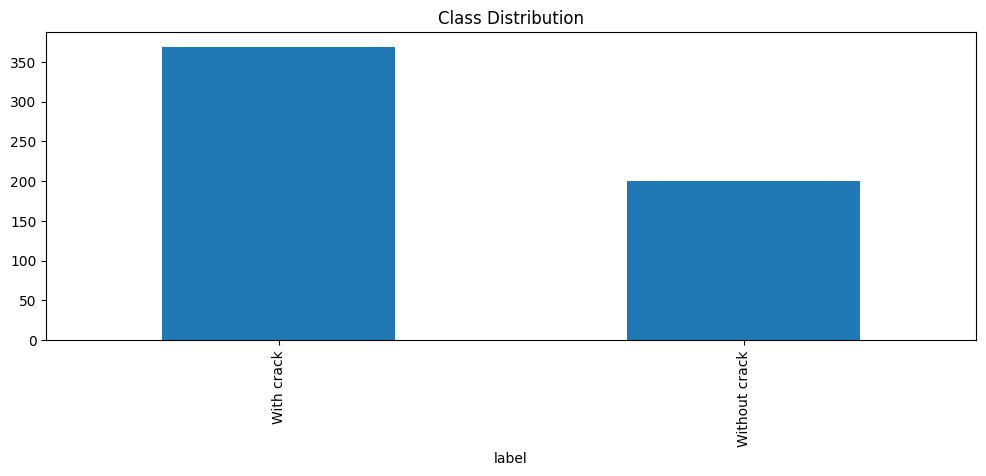

In [3]:
print("Total images:", len(df))
print("Total classes:", df['label'].nunique())

class_counts = df['label'].value_counts()
display(class_counts)

class_counts.plot(kind='bar', figsize=(12,4))
plt.title("Class Distribution")
plt.show()

In [4]:
class_distribution = df['label'].value_counts().reset_index()
class_distribution.columns = ['Class', 'Count']
class_distribution['Percentage'] = (
    class_distribution['Count'] / len(df) * 100
)

display(class_distribution)

,Class,Count,Percentage
0,With crack,369,64.850615
1,Without crack,200,35.149385


# 2. Duplicate Detection (Perceptual Hash)

**2.1 Detection of Duplicates**

In [5]:
hashes = {}

duplicates = []

for path in tqdm(df['path']):
    img = Image.open(path)
    ph = imagehash.phash(img)
    
    if ph in hashes:
        duplicates.append((hashes[ph], path))
    else:
        hashes[ph] = path

print("Duplicate pairs found:", len(duplicates))

100%|██████████| 569/569 [00:05<00:00, 109.04it/s]

Duplicate pairs found: 65


**2.2 Remove Exact + Near Duplicates BEFORE Split**

In [6]:
from PIL import Image
import imagehash
from tqdm import tqdm

hash_dict = {}
duplicate_indices = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img = Image.open(row['path']).convert('RGB')
        ph = imagehash.phash(img)
        
        if ph in hash_dict:
            duplicate_indices.append(idx)
        else:
            hash_dict[ph] = idx
    except Exception as e:
        print("Error reading:", row['path'])

print("Total duplicates detected:", len(duplicate_indices))

# Remove duplicates
df_clean = df.drop(index=duplicate_indices).reset_index(drop=True)

print("Original dataset size:", len(df))
print("Clean dataset size:", len(df_clean))

100%|██████████| 569/569 [00:01<00:00, 293.68it/s]

Total duplicates detected: 65
Original dataset size: 569
Clean dataset size: 504


**Save Clean Metadata**

In [7]:
df.to_csv("/kaggle/working/clean_dataset_metadata.csv", index=False)
print("Clean dataset metadata saved successfully.")

Clean dataset metadata saved successfully.


**2.3 Basic Statistics after Duplicates Removal**

Total images: 504
Total classes: 2


label
With crack       304
Without crack    200
Name: count, dtype: int64

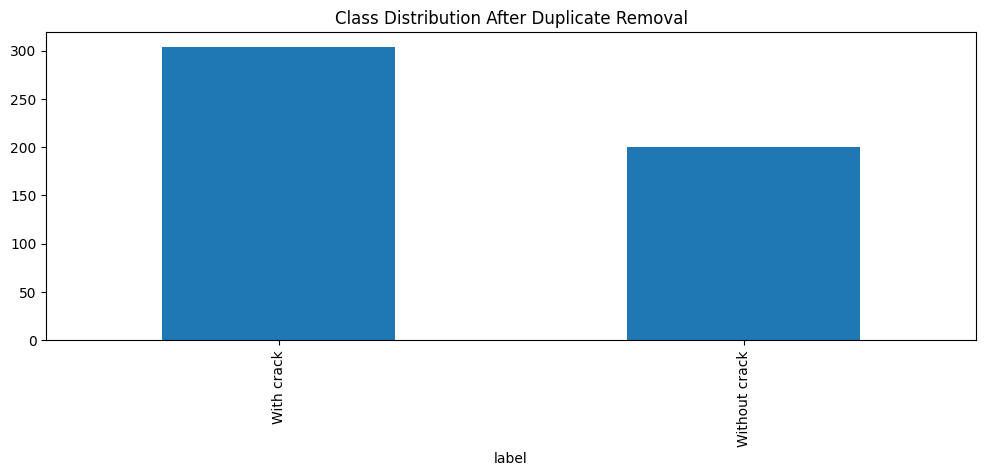

In [8]:
print("Total images:", len(df_clean))
print("Total classes:", df_clean['label'].nunique())

class_counts = df_clean['label'].value_counts()
display(class_counts)

class_counts.plot(kind='bar', figsize=(12,4))
plt.title("Class Distribution After Duplicate Removal")
plt.show()

In [9]:
class_distribution = df_clean['label'].value_counts().reset_index()
class_distribution.columns = ['Class', 'Count']
class_distribution['Percentage'] = (
    class_distribution['Count'] / len(df_clean) * 100
)

display(class_distribution)

,Class,Count,Percentage
0,With crack,304,60.31746
1,Without crack,200,39.68254


# 3. Color Distribution Analysis (RGB + HSV)

**3.1 RGB Histogram**

In [10]:
def compute_rgb_stats(image_paths, sample_size=500):
    means, stds = [], []
    
    for path in tqdm(image_paths[:sample_size]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        means.append(np.mean(img, axis=(0,1)))
        stds.append(np.std(img, axis=(0,1)))
    
    return np.array(means), np.array(stds)

means, stds = compute_rgb_stats(df_clean['path'].tolist())

print("RGB Mean:", means.mean(axis=0))
print("RGB Std:", stds.mean(axis=0))

100%|██████████| 500/500 [00:08<00:00, 58.35it/s]

RGB Mean: [166.1022634  160.05041357 153.52643714]
RGB Std: [29.01691605 26.30367559 23.61992368]


**3.2 HSV Histogram**

100%|██████████| 500/500 [00:01<00:00, 359.48it/s]


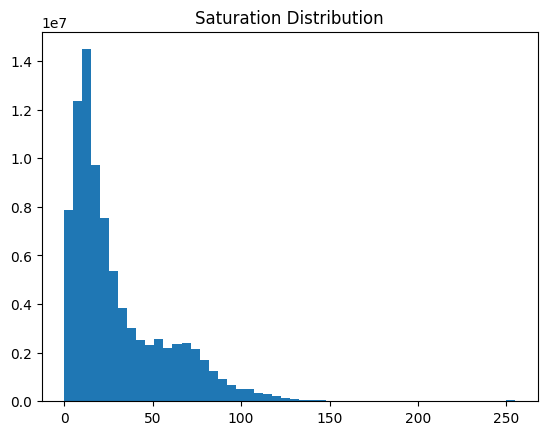

In [11]:
def hsv_distribution(image_paths, sample_size=500):
    hsv_values = []
    
    for path in tqdm(image_paths[:sample_size]):
        img = cv2.imread(path)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hsv_values.append(hsv.reshape(-1,3))
    
    hsv_values = np.vstack(hsv_values)
    return hsv_values

hsv_vals = hsv_distribution(df_clean['path'].tolist())

plt.hist(hsv_vals[:,1], bins=50)
plt.title("Saturation Distribution")
plt.show()

# 4. Resolution & Aspect Ratio Audit

In [12]:
widths, heights = [], []

for path in tqdm(df_clean['path']):
    img = Image.open(path)
    widths.append(img.width)
    heights.append(img.height)

df_clean['width'] = widths
df_clean['height'] = heights
df_clean['aspect_ratio'] = df_clean['width'] / df_clean['height']

df_clean[['width','height']].describe()

100%|██████████| 504/504 [00:00<00:00, 1354.34it/s]


,width,height
count,504.0,504.0
mean,351.0,500.0
std,0.0,0.0
min,351.0,500.0
25%,351.0,500.0
50%,351.0,500.0
75%,351.0,500.0
max,351.0,500.0


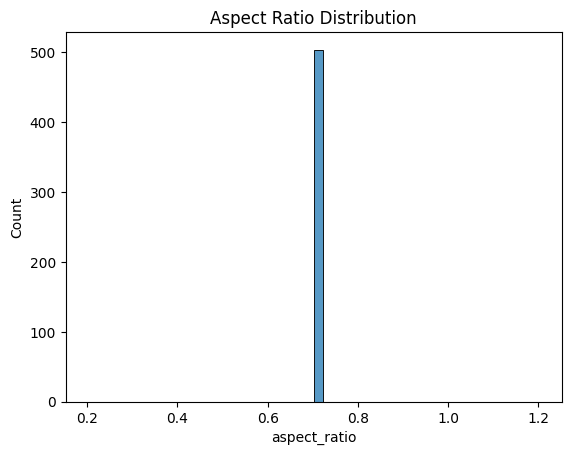

In [13]:
sns.histplot(df_clean['aspect_ratio'], bins=50)
plt.title("Aspect Ratio Distribution")
plt.show()

# 5. Sharpness (Laplacian Variance)

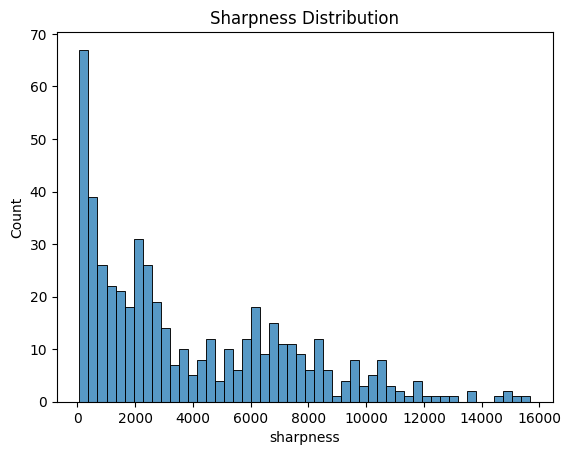

In [14]:
def laplacian_variance(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

df_clean['sharpness'] = df_clean['path'].apply(laplacian_variance)

sns.histplot(df_clean['sharpness'], bins=50)
plt.title("Sharpness Distribution")
plt.show()

In [15]:
sharpness_stats = df_clean['sharpness'].describe()

print("Sharpness Summary Statistics:")
display(sharpness_stats)

print("\nAdditional Metrics:")
print("Median:", df_clean['sharpness'].median())
print("IQR:", df_clean['sharpness'].quantile(0.75) - df_clean['sharpness'].quantile(0.25))
print("Min:", df_clean['sharpness'].min())
print("Max:", df_clean['sharpness'].max())

Sharpness Summary Statistics:


count      504.000000
mean      3906.408413
std       3478.885081
min         75.021145
25%        881.319330
50%       2640.744180
75%       6435.512940
max      15684.432801
Name: sharpness, dtype: float64


Additional Metrics:
Median: 2640.744179801511
IQR: 5554.193610058297
Min: 75.0211451783346
Max: 15684.432800966584


In [16]:
blur_threshold = 1000

blurry_count = (df_clean['sharpness'] < blur_threshold).sum()
print(f"\nImages below blur threshold ({blur_threshold}): {blurry_count}")


Images below blur threshold (1000): 132


# 6. White Balance (Gray-World Check)

In [17]:
def gray_world_shift(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    avg = np.mean(img, axis=(0,1))
    return avg

rgb_avg = df_clean['path'].sample(300).apply(gray_world_shift)
rgb_avg = np.array(list(rgb_avg))

print("Channel means:", rgb_avg.mean(axis=0))

Channel means: [165.22173852 159.5639667  153.45719189]


# 7. Leakage-Safe Stratified Train/Test Split

In [18]:
from sklearn.model_selection import train_test_split

SEED = 42

train_df, test_df = train_test_split(
    df_clean,
    test_size=0.2,
    stratify=df_clean['label'],
    random_state=SEED
)

print("\nTrain size:", len(train_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df['label'].value_counts())

print("\nTest class distribution:")
print(test_df['label'].value_counts())


Train size: 403
Test size: 101

Train class distribution:
label
With crack       243
Without crack    160
Name: count, dtype: int64

Test class distribution:
label
With crack       61
Without crack    40
Name: count, dtype: int64


**Confirm No Duplicate Leakage Across Split**

In [19]:
train_hashes = set()
test_hashes = set()

for path in train_df['path']:
    img = Image.open(path).convert('RGB')
    train_hashes.add(imagehash.phash(img))

for path in test_df['path']:
    img = Image.open(path).convert('RGB')
    test_hashes.add(imagehash.phash(img))

leakage = train_hashes.intersection(test_hashes)

print("\nDuplicate leakage across splits:", len(leakage))


Duplicate leakage across splits: 0


# 8. Augmentation Probe

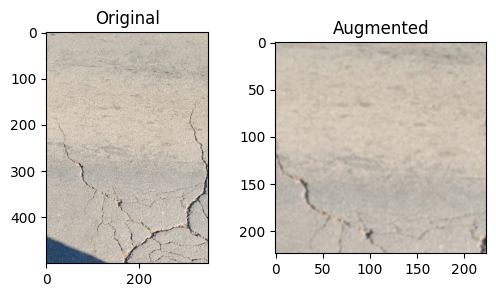

In [20]:
import torchvision.transforms as T

transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(),
    T.GaussianBlur(3)
])

sample_img = Image.open(df_clean['path'].iloc[0])

aug_img = transform(sample_img)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(sample_img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(aug_img)
plt.title("Augmented")
plt.show()

# 9. EDA Summary

The dataset is structurally consistent, duplicate-free, and suitable for supervised binary image classification.
Preprocessing integrity has been maintained throughout the pipeline, ensuring that downstream modeling will be statistically valid and experimentally reproducible.

The dataset is ready for model development using transfer learning or data augmentation strategies to mitigate limited sample size.